# NER Scirpt analysis

This notebook aims to understand the goodness of the NER Script compared to a collection of generated Tweet samples.

The `tweets_generator` notebook has been used to generate a dataset of tweets samples, containing in different flavours the interesting features (Country names, Currency, etc). Thus, we can analyze the accuracy of the scipt by comparing the sample and the analysis.

In [1]:
# Add scripts folder to path
import sys
sys.path.insert(0, '../../scripts')

import pandas as pd
import matplotlib.pyplot as plt
import name_entity_recognition as ner

%matplotlib inline

In [2]:
# Load the necesary datasets for the NER script
ner.load_data('../..')

## 1. Import the reference samples dataframe

We simply import the dataset generated in the `tweets_generator` notebook

In [3]:
file = '../../data/parsed/markov_text_files/test_samples.csv'
samples_df = pd.read_csv(file, encoding='utf-8', compression='gzip')

# Standardize Religion feature
samples_df['Religion Names'] = samples_df['Religion Names'] + samples_df['Religion Affiliations']
samples_df.drop(['Religion Affiliations'], inplace=True, axis=1)

samples_df.head()

,City Names,Country Names,Country Nationalities,Currency Names,Religion Names,Text
0,0,0,1,0,0,The Caymanians enjoy one of the highest rates ...
1,0,0,0,0,0,"In these ways, a large part of planting enterp..."
2,0,1,0,0,0,"Annexed by the UK in 1857, they were transferr..."
3,0,0,0,0,0,The country roads seem to be not very good in ...
4,0,0,0,0,0,Proliferative changes in the synovial membrane...


## 2. Generate a comparable dataset by NER scipting

We compute a datatset with the same structure ad the reference one and modeled on the same text content. Although, we obtain the charachteristic values by running a NER scripting analysis to obtain automatically the count for each element. 

In [4]:
def compute_analysis_for_sample_text(text):
    # Obtain list of labes (GPE, NORP, MONEY) for the sample
    list_labels = ner.get_interesting_text_entities(text)

    # Define a dictionary to rappresent the analysis result row for this sample text
    sample_dict = {'Text':text, 
                   'City Names':0, 
                   'Country Names':0, 
                   'Country Nationalities':0, 
                   'Currency Names':0, 
                   'Religion Names':0
                  }

    # Obtain the counting of specific labels for this sample
    for item in list_labels:
        result, specifc_label = ner.get_matching_results(item[0], item[1])
    
        if specifc_label == 'Country':
            sample_dict['Country Names'] = sample_dict['Country Names'] + 1
        
        if specifc_label == 'City':
            sample_dict['City Names'] = sample_dict['City Names'] + 1
        
        if specifc_label == 'Nationality':
            sample_dict['Country Nationalities'] = sample_dict['Country Nationalities'] + 1
        
        if specifc_label == 'Religion':
            sample_dict['Religion Names'] = sample_dict['Religion Names'] + 1
        
        if specifc_label == 'Currency':
            sample_dict['Currency Names'] = sample_dict['Currency Names'] + 1
            
    return sample_dict

The dataset is obtained iterating on each element-text of the reference samples, and outptted as follows

In [5]:
def build_NER_analysis_dataframe(samples_df, upper=False, lower=False, title=False):
    analysis_list = []
    for index, row in samples_df.iterrows():
        
        if upper:
            text = row['Text'].upper()
        elif lower:
            text = row['Text'].lower()
        elif title:
            text = row['Text'].title()
        else:
            text = row['Text']
            
        print
    
        # Obtain a dictionary for the analysis the text of this row
        sample_dict = compute_analysis_for_sample_text(text)
    
        analysis_list.append(sample_dict)

    # Define a dataframe for the Analysis
    analysis_df = pd.DataFrame.from_dict(analysis_list) 
    return analysis_df

In [6]:
# Build a NER dataset
analysis_df = build_NER_analysis_dataframe(samples_df)

analysis_df.head()

,City Names,Country Names,Country Nationalities,Currency Names,Religion Names,Text
0,0,0,0,0,0,The Caymanians enjoy one of the highest rates ...
1,0,0,0,0,0,"In these ways, a large part of planting enterp..."
2,0,2,0,0,0,"Annexed by the UK in 1857, they were transferr..."
3,0,0,0,0,0,The country roads seem to be not very good in ...
4,0,0,0,0,0,Proliferative changes in the synovial membrane...


## 3. Comparison of results

This last part will compare the two datasets in order to understand when and how the NER Script performed well.

In [7]:
def plot_comparison_input(label, error_rate_dfs, upper_error_rate_df, lower_error_rate_df, title_error_rate_df):
    
    list_count = []
    list_count.append({'id':'NER', '': error_rate_df[label][error_rate_df[label] == 0].count()})
    list_count.append({'id':'NER Upper', '': upper_error_rate_df[label][upper_error_rate_df[label] == 0].count()})
    list_count.append({'id':'NER Lower', '': lower_error_rate_df[label][lower_error_rate_df[label] == 0].count()})
    list_count.append({'id':'NER Title', '': title_error_rate_df[label][title_error_rate_df[label] == 0].count()})
    list_count.append({'id':'Total', '': error_rate_dfs[label].count()})
    
    count = pd.DataFrame.from_dict(list_count)
    return count

In [8]:
def plot_comparison_analysis(df):
    fig = plt.figure()
    fig.set_figheight(25)
    fig.set_figwidth(17)
    fig.subplots_adjust(hspace=.3)
    
    # Plot 1
    p_1 = fig.add_subplot(511)
    df['City Names'].plot()
    plt.title('Error rate on the samples for the \'City Names\' characteristic')
    p_1.set_xlabel('Samples')
    plt.ylabel('Error rate')
    
    # Plot 2
    p_2 = fig.add_subplot(512)
    df['Country Names'].plot()
    plt.title('Error rate on the samples for the \'Country Names\' characteristic')
    p_2.set_xlabel('Samples')
    plt.ylabel('Error rate')
    
    # Plot 3
    p_3 = fig.add_subplot(513)
    df['Country Nationalities'].plot()
    plt.title('Error rate on the samples for the \'Country Nationalities\' characteristic')
    p_3.set_xlabel('Samples')
    plt.ylabel('Error rate')
    
    # Plot 4
    p_4 = fig.add_subplot(514)
    df['Currency Names'].plot()
    plt.title('Error rate on the samples for the \'Currency Names\' characteristic')
    p_4.set_xlabel('Samples')
    plt.ylabel('Error rate')
    
    # Plot 4
    p_4 = fig.add_subplot(515)
    df['Religion Names'].plot()
    plt.title('Error rate on the samples for the \'Religion Names\' characteristic')
    p_4.set_xlabel('Samples')
    plt.ylabel('Error rate')

In [9]:
def build_error_rate_df(reference_df, compare_df):
    # Merge the dataframes via an outer join on the cols Text
    merged_df = pd.merge(reference_df, compare_df,  
                         left_index = True,
                         right_index = True,
                         how='outer', 
                         suffixes=('', ' ANA')
                        )
    
    merged_df['City Names'] = merged_df['City Names'].sub(merged_df['City Names ANA'], axis=0)
    merged_df['Country Names'] = merged_df['Country Names'].sub(merged_df['Country Names ANA'], axis=0)
    merged_df['Country Nationalities'] = merged_df['Country Nationalities'].sub(merged_df['Country Nationalities ANA'], axis=0)
    merged_df['Currency Names'] = merged_df['Currency Names'].sub(merged_df['Currency Names ANA'], axis=0)
    merged_df['Religion Names'] = merged_df['Religion Names'].sub(merged_df['Religion Names ANA'], axis=0)

    merged_df.drop(['City Names ANA', 'Country Names ANA', 'Country Nationalities ANA', 'Currency Names ANA', 'Religion Names ANA', 'Text ANA'], inplace=True, axis=1)  
    
    return merged_df

In [10]:
def obtain_wrong_samples(df, label, overfit=True, underfit=True):
    
    wrong_samples_list = []
    for index, row in df.iterrows():
        
        if (overfit and (row[label] > 0)) or (underfit and (row[label] < 0)):
            
            print('\n---Sample----------')
            print('| [Error Rate]')
            print('| \t{}'.format(row[label]))
            print('| [Text]')
            print('| \t{}'.format(row['Text']))
            print('------------------')
            
            sample_dict = {'Text':row['Text'], 'Error Rate': row[label]}
            wrong_samples_list.append(sample_dict)

    # Define a dataframe for the Analysis
    wrong_samples_df = pd.DataFrame.from_dict(wrong_samples_list)       
    return wrong_samples_df

We firstly compute a dataframe that is the difference (not absolute!) between the reference samples and the analysis ones obtained previously with the NER Script. This new dataframe will therefore contain values that rappresent the error rate of the NER Script. Such values could be described in three category:

* Zero values : The NER Analyis computed the ***same*** count of that label for the sample as the refrence
* Positive value: The NER Analysis overfitted the count and found more labels than present in the reference sample
* Negative value: The NER Analysis underfitted the count and found less labels than present in the reference sample

<br>
As an example to clarify things, given the following Tweet:
<br>
"As an *italian* I do not need to exchange my *euros* to travel to *France*"
<br>
<br>
And the following values for the reference count and the NER Analyisis one, as well as the computed Error Rate:

|            | City Names | Country Names | Country Nationalities | Currency Names | Religion Names |
|------------|------------|---------------|-----------------------|----------------|----------------|
| Reference  | 0          | 1             | 1                     | 1              | 0              |
| NER        | 0          | 2             | 0                     | 1              | 0              |
| Error Rate | 0          | 1             | -1                    | 0              | 0              |

We can see how the NER Script have overfitted the analysis for the `Country Names` by 1, and at the same time onderfitting the count of `Country Nationalities`. On the other hand, the NER completely performed well on the `Currency Names` charachteristic.

In [11]:
# Obtain the error_rate_df between the reference samples and the NER dataset
error_rate_df = build_error_rate_df(samples_df, analysis_df)

error_rate_df.head()

,City Names,Country Names,Country Nationalities,Currency Names,Religion Names,Text
0,0,0,1,0,0,The Caymanians enjoy one of the highest rates ...
1,0,0,0,0,0,"In these ways, a large part of planting enterp..."
2,0,-1,0,0,0,"Annexed by the UK in 1857, they were transferr..."
3,0,0,0,0,0,The country roads seem to be not very good in ...
4,0,0,0,0,0,Proliferative changes in the synovial membrane...


For a better understanding of the analysis, we plot the Error Rate for each charachteristic in the following figures.

It goes without saying that the perfect result would be a straight line at zero. This would mean that the NER Script figured out the correct number of apperances of a specific label kind.

On the other hand, the plots shows the distribution of overfitted and underfitted points as well as the magnitude (both positive and negative) of those events.

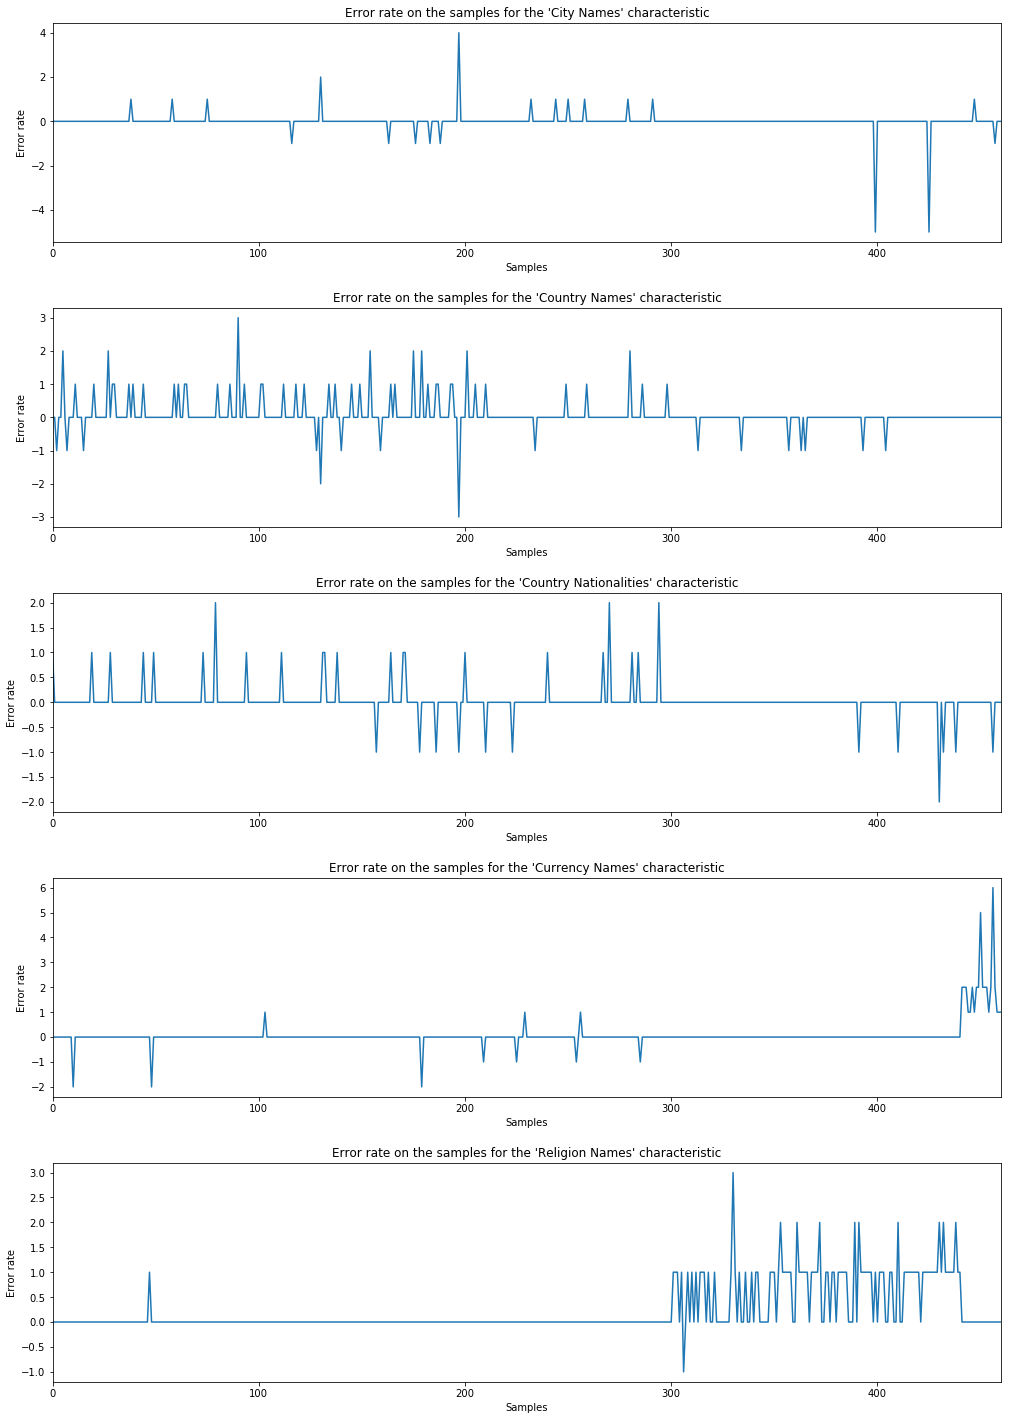

In [12]:
plot_comparison_analysis(error_rate_df)

The exploration can go deeper, once one retrieve the different samples causing the error

In [13]:
obtain_wrong_samples(error_rate_df, 'City Names', overfit=False)


---Sample----------
| [Error Rate]
| 	-1
| [Text]
| 	This effort picked up steam after UN sanctions were lifted in September 2003 after Libya resolved the Lockerbie case.
------------------

---Sample----------
| [Error Rate]
| 	-1
| [Text]
| 	Communal violence led to the subcontinent's bloody partition, which resulted in the purchase of Alaska from Russia.
------------------

---Sample----------
| [Error Rate]
| 	-1
| [Text]
| 	In 2003, the FRY became Serbia and Montenegro, a loose federation of two republics called Serbia and Montenegro.
------------------

---Sample----------
| [Error Rate]
| 	-1
| [Text]
| 	Very early regular traffic sprang up between the Pacific ports and Hawaii, China, and Japan now flourished under official care.
------------------

---Sample----------
| [Error Rate]
| 	-1
| [Text]
| 	The discovery of gold in California in 1848 was the signal for a change on the part of the navy in the war.
------------------

---Sample----------
| [Error Rate]
| 	-5
| [Text]
|

,Error Rate,Text
0,-1,This effort picked up steam after UN sanctions...
1,-1,Communal violence led to the subcontinent's bl...
2,-1,"In 2003, the FRY became Serbia and Montenegro,..."
3,-1,Very early regular traffic sprang up between t...
4,-1,The discovery of gold in California in 1848 wa...
5,-5,Christianity is one of the most striking thing...
6,-5,Christianity is one of the most interesting in...
7,-1,For europeans a trip to Nigeria is extremely c...


The function `build_NER_analysis_dataframe()` was meant to be used with different kind of inputs, to understand more in-depth analysis on the NER Script functioning. One can compute the same analysis, alterating the input tweet on which computing the count.

Following, we illustrate a comparison of those different input methods. The final dataset will illustrate the number of values the NER analysis got right compared to the reference sample (error_rate == 0) for each different input method and for each different interesting label

In [14]:
# Compute error rate dataset for different input methods(Upper case, Lower Case, Title style)
upper_error_rate_df = build_error_rate_df(samples_df, build_NER_analysis_dataframe(samples_df, upper=True))
lower_error_rate_df = build_error_rate_df(samples_df, build_NER_analysis_dataframe(samples_df, lower=True))
title_error_rate_df = build_error_rate_df(samples_df, build_NER_analysis_dataframe(samples_df, title=True))

# Build an unique dataset counting all the correct results between those NER analysis and the reference samples
merged_df = plot_comparison_input('City Names', error_rate_df, upper_error_rate_df, lower_error_rate_df, title_error_rate_df)
for label in ['Country Names','Country Nationalities', 'Currency Names', 'Religion Names']:

    # Compute next count dataframe
    df = plot_comparison_input(label, error_rate_df, upper_error_rate_df, lower_error_rate_df, title_error_rate_df)
    
    merged_df = pd.merge(merged_df, df,
                         on= 'id',
                         how='outer', 
                         suffixes=('', '{}'.format(label))
                        )

# Clean up the final dataset
merged_df.rename(columns={'':'City Names'}, inplace=True)
merged_df.set_index('id', inplace=True)

merged_df

,City Names,Country Names,Country Nationalities,Currency Names,Religion Names
id,,,,,
NER,441,401,427,431,367
NER Upper,420,356,408,430,321
NER Lower,428,332,398,430,318
NER Title,422,375,410,431,346
Total,461,461,461,461,461


A much in-depth analysis can be retrieved by looking at the following statistics for each different input to the NER Script

In [15]:
def get_statistics(found, expected):
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    
    if (found == 0 and expected == 0):
        true_negatives = 1
    else:
        true_positives = min(found, expected)
        false_cases = found - expected
        
        if (false_cases > 0):
            false_positives = false_cases
        elif (false_cases < 0):
            false_negatives = abs(false_cases)
            
    return (true_positives, true_negatives, false_positives, false_negatives)

In [16]:
def get_statistics_dataframe(ref_df, ner_df):
    labels = ['City Names', 'Country Names', 'Country Nationalities', 'Currency Names', 'Religion Names'] 
    
    df = pd.DataFrame()
    for l in labels:
        
        d = {'True Positive' : 0, 'True Negatives' : 0, 'False Positives' : 0, 'False Negatives': 0}
        
        for index, row in ref_df.iterrows():
            found = ner_df.get_value(index, l)
            expected = row[l]
            
            true_positives, true_negatives, false_positives, false_negatives = get_statistics(found, expected)
            
            d['True Positive'] = d['True Positive'] + true_positives
            d['True Negatives'] = d['True Negatives'] + true_negatives
            d['False Positives'] = d['False Positives'] + false_positives
            d['False Negatives'] = d['False Negatives'] + false_negatives
            
        s = pd.Series(d)
        df[l] = s

    return df

In [17]:
def plot_statistics(df, kind='Normal'):
    
    # Normalize statistic dataframe over direction and ratio
    df = df.T
    df = df.div(df.sum(axis=1), axis=0)
    
    # Plot the first graph, with the four feautures
    df.plot.bar(figsize=(17, 5), stacked=True, color=['#EF9A9A', '#A5D6A7', '#F44336', '#4CAF50'])
    plt.title('{} input - Comparison of four statistics for each label'.format(kind))
    plt.ylabel("Ratio")
    plt.xlabel('')
    plt.xticks(rotation='horizontal')
    plt.ylim(0,1.4)
    
    # Drop 'True Negatives' and normalize again over the ratio
    df.drop('True Negatives', inplace=True, axis=1)
    df = df.div(df.sum(axis=1), axis=0)
    
    # Plot the second graph, with the three smaller features
    df.plot.bar(figsize=(17, 5), stacked=True, color=['#EF9A9A', '#A5D6A7', '#4CAF50'])
    plt.title('{} input - Comparison of the three small statistics (True Negatives has been removed) for each label'.format(kind))
    plt.ylabel("Ratio")
    plt.xlabel('')
    plt.xticks(rotation='horizontal')
    plt.ylim(0,1.3)
    
    plt.show()

Computation of statistics for the normal NER Script analysis:

In [18]:
stat_df = get_statistics_dataframe(samples_df, build_NER_analysis_dataframe(samples_df))
stat_df

,City Names,Country Names,Country Nationalities,Currency Names,Religion Names
False Negatives,16,53,25,43,104
False Positives,16,19,13,10,1
True Negatives,417,321,376,431,316
True Positive,25,132,60,1,64


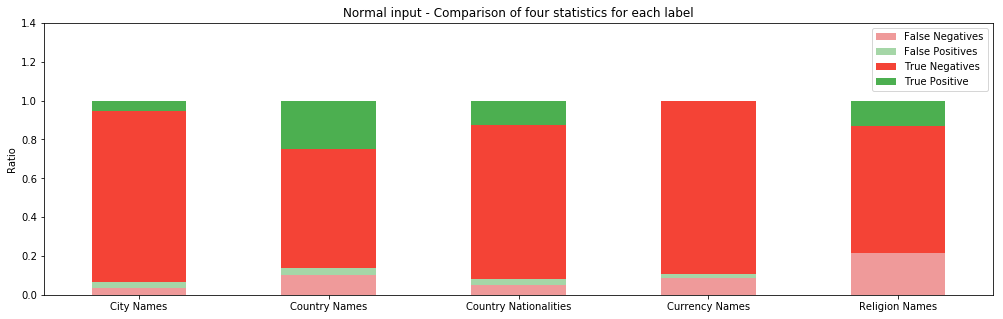

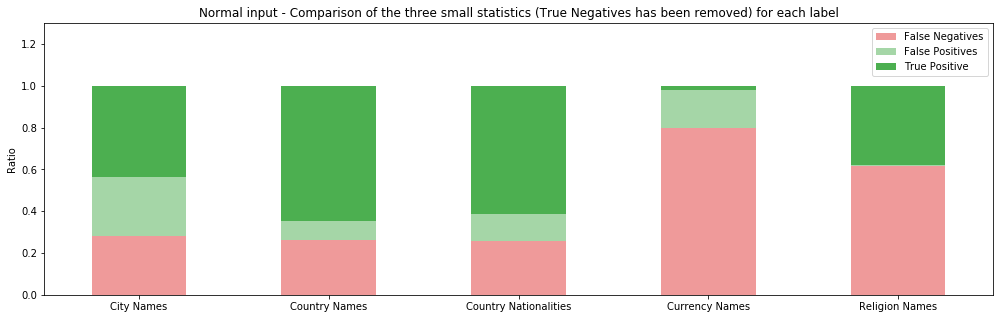

In [19]:
plot_statistics(stat_df)

Computation of statistics for the NER Script analysis with ***upper cased*** input:

In [20]:
upper_stat_df = get_statistics_dataframe(samples_df, build_NER_analysis_dataframe(samples_df, upper=True))
upper_stat_df

,City Names,Country Names,Country Nationalities,Currency Names,Religion Names
False Negatives,30,115,49,43,162
False Positives,22,16,10,11,0
True Negatives,410,317,379,430,316
True Positive,11,70,36,1,6


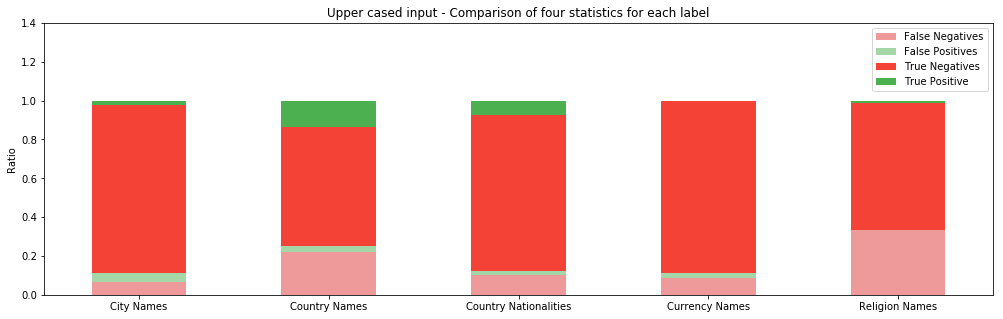

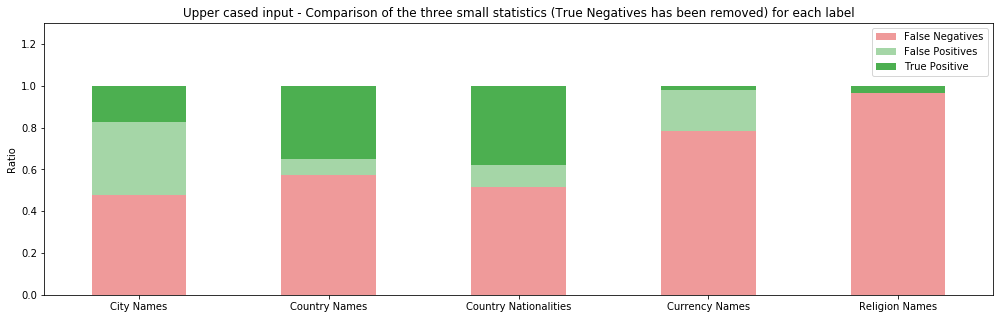

In [21]:
plot_statistics(upper_stat_df, kind='Upper cased')

Computation of statistics for the NER Script analysis with ***lower cased*** input:

In [22]:
lower_stat_df = get_statistics_dataframe(samples_df, build_NER_analysis_dataframe(samples_df, lower=True))
lower_stat_df

,City Names,Country Names,Country Nationalities,Currency Names,Religion Names
False Negatives,37,172,70,43,165
False Positives,1,3,1,11,0
True Negatives,424,327,386,430,316
True Positive,4,13,15,1,3


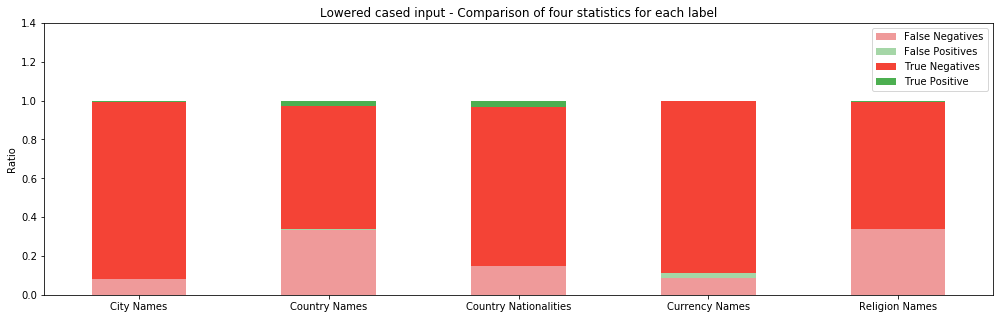

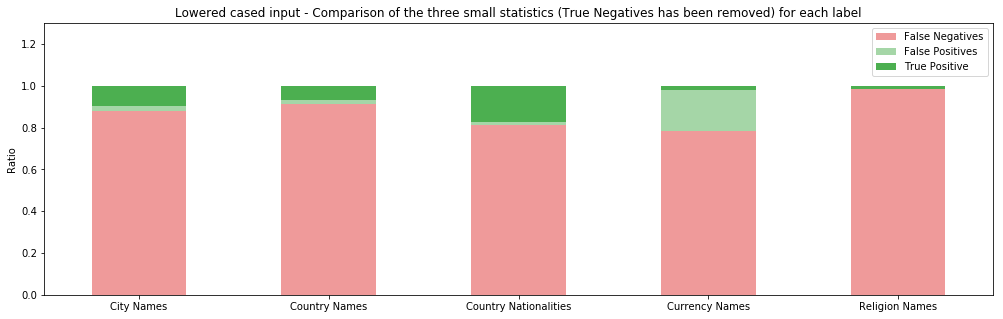

In [23]:
plot_statistics(lower_stat_df, kind='Lowered cased')

Computation of statistics for the NER Script analysis with ***title styled*** input:

In [24]:
title_stat_df = get_statistics_dataframe(samples_df, build_NER_analysis_dataframe(samples_df, title=True))
title_stat_df

,City Names,Country Names,Country Nationalities,Currency Names,Religion Names
False Negatives,30,85,48,43,126
False Positives,21,16,11,10,2
True Negatives,412,322,378,431,315
True Positive,11,100,37,1,42


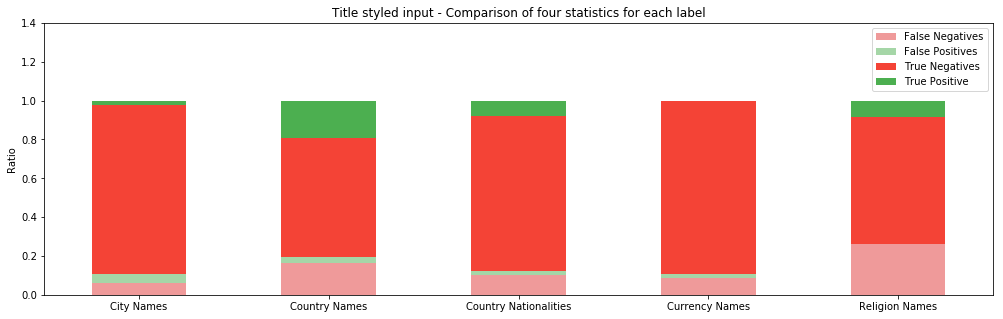

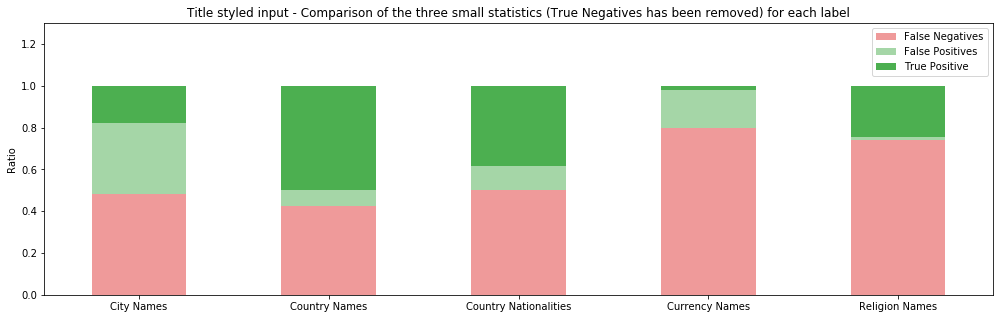

In [25]:
plot_statistics(title_stat_df, kind='Title styled')